In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import scissor
import secretkeyrate as skr

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
## Comments
#### Holevo bound is always nan and I don't understand why

In [2]:
dimension = 5

a = qutip.destroy(dimension)
q = (1/np.sqrt(2))*(a + a.dag())
p = -(1j/np.sqrt(2))*(a - a.dag())
quadratures = [q, p]

In [27]:
single_photon_efficiency = 1
bob_transmission = 1
alice_transmission = 1

rho_ab = scissor.eb_quantum_scissor(0.6, dimension)
cov_ab = skr.covariance_matrix_2mode(quadratures, rho_ab)
I_ab = skr.mutual_information(cov_ab)
chi = skr.holevo_information(cov_ab)
key_rate = 0.9*(I_ab - chi)

In [ ]:
## Copied from library so I can understand what is wrong

def cov_block(cov):
    '''
    Take the blocks on 2 mode covariance matrix related to mode 1, mode 2 and correlations.
    Parameters
        cov: ndarray
            2mode covariance matrix
    Return
        block_A: ndarray
            1mode covariance matrix of first mode
        block_B: ndarray
            1mode covariance matrix of second mode
        block_corr: ndarray
            correlations between modes
    '''
    block_A = [[cov[0,0], cov[0,1]],[cov[1,0], cov[1,1]]]
    block_B = [[cov[2,2], cov[2,3]],[cov[3,2], cov[3,3]]]
    block_corr = [[cov[0,2], cov[0,3]],[cov[1,2], cov[1,3]]]
    
    return block_A, block_B, block_corr

def homodyne_measurement(cov, quadrature, mode):
    '''
    Perform a homodyne measurement in one mode of a 2mode system described by a covariance matrix.
    Parameters
        cov: ndarray
            2-mode covariance matrix
        quadrature: string 
            quadrature being measured (possibilities: 'q', 'p', 'heterodyne')
        mode: int
            mode on which measurements are being performed (possibilities: 0 or 1)
    Return
        reduced_cov: ndarray
            1-mode covariance matrix of the remaining system
    '''
    block_A, block_B, block_corr = cov_block(cov)
    
    if quadrature == 'q':
        meas = [[1,0],[0,0]]
        var = cov[0 + 2*mode][0 + 2*mode]
    elif quadrature == 'p':
        meas = [[0,0],[0,1]]
        var = cov[1 + 2*mode][1 + 2*mode]
    elif quadrature == 'heterodyne':
        meas = np.array(qutip.Qobj(block_B) + qutip.Qobj([[1,0],[0,1]]))
        var = 1
    else:
        print('Quadrature not recognized')
        return
    
    if mode == 0:
        reduced_cov = np.array(qutip.Qobj(block_A) - (1/var)*qutip.Qobj(block_corr)*qutip.Qobj(meas)*(qutip.Qobj(block_corr).conj()))
    elif mode == 1:
        reduced_cov = np.array(qutip.Qobj(block_B) - (1/var)*qutip.Qobj(block_corr)*qutip.Qobj(meas)*(qutip.Qobj(block_corr).conj()))
        
    return reduced_cov

def sympletic_eigenvalues(cov):
    '''
    Calculates the positive sympletic eigenvalue of a single-mode or two-mode covariance matrix
    Parameters:
        cov: ndarray
            Covariance matrix
    Return:
        e or e1, e2: float
            Sympletic eigenvalues
    '''
    Omega = 1j*qutip.sigmay()
    zero2 = qutip.qeye(2)-qutip.qeye(2)
    Omega2 = np.block([[Omega, zero2],[zero2, Omega]])
    
    if len(cov) == 2:
        # Covariance matrix describes a single-mode system
        sigma = qutip.Qobj(1j*Omega*cov)
        _, e = sigma.eigenenergies()
        return e
    if len(cov) == 4:
        # Covariance matrix describes a two-mode system
        sigma = qutip.Qobj(1j*Omega2*cov)
        _, _, e1, e2 = sigma.eigenenergies()
        return e1, e2

def von_neumann_entropy(cov):
    '''
    Calculate the Von Neumann entropy of a covariance matrix in terms of the sympletic eigenvalues
    Parameters
        cov: ndarray
            Covariance matrix
    Return
        S: float
            Von Neumann entropy
    '''
    if len(cov) == 4:
        # Two-mode system
        e1, e2 = sympletic_eigenvalues(cov)
        eigenvalues = [e1, e2]
    elif len(cov) == 2:
        # Single-mode system
        e = sympletic_eigenvalues(cov)
        eigenvalues = [e]
        
    S = 0
    for e in eigenvalues:
        plus = (e+1)/2
        minus = (e-1)/2
        S += plus*np.log2(plus) - minus*np.log2(minus)
    
    return S

def holevo_information(cov, quadrature = 'heterodyne', mode = 1):
    '''
    Calculate Eve's Holevo information assuming the Gaussian optimality.
    Parameters
        cov: ndarray
            2-mode covariance matrix
        quadrature: string
            quadrature being measured (possibilities: 'q', 'p', 'heterodyne')
        mode: int
            mode on which measurements are being performed (possibilities: 0 or 1)
    Return
        chi: float
            Eve's Holevo information
    '''
    S_AB = von_neumann_entropy(cov)
    
    reduced_cov = homodyne_measurement(cov, quadrature, mode)
    S_A = von_neumann_entropy(reduced_cov)
    
    chi = S_AB - S_A
    
    return chi

In [13]:
def mutinf(r, dimension):
    rho_ab = scissor.eb_quantum_scissor(r, dimension)
    cov_ab = skr.covariance_matrix_2mode(quadratures, rho_ab)
    I_ab = skr.mutual_information(cov_ab)

    return I_ab

In [17]:
r_list = np.linspace(0, 2, 100)

vector_Iab = np.vectorize(mutinf)
I_ab_list = vector_Iab(r_list, dimension)

C:\Users\lunfa\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


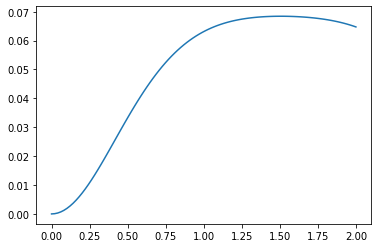

In [18]:
plt.figure()
plt.plot(r_list, I_ab_list)
plt.show()